In [1]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(2017) # set random seed value to get reproducible results

In [3]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = 10, 10

def forward_feature_selection(rsf, X, y, title):
    features = list(X.columns)
    selected_features = []
    scores = []
    
    for i in tqdm(range(X.shape[1])):
        best_score = 0
        next_feat = ''
        for feat in features:
            selected_features.append(feat)
            temp_X = X[selected_features]
            temp_scores = cross_validate(rsf, temp_X, y, cv=5)
            temp_score = temp_scores['test_score'].mean()
            if temp_score > best_score:
                best_score = temp_score
                next_feat = feat
            selected_features.pop()
        #print('Added Feature:', next_feat)
        selected_features.append(next_feat)
        features.remove(next_feat)
        scores.append(best_score)
        
    print('Ordering of Features:', selected_features)
    
    plt.title(title)
    plt.xlabel('# of Features')
    plt.ylabel('score')
    plt.plot(list(range(X.shape[1])), scores)

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


In [4]:
def backward_feature_selection(rsf, X, y, title):
    features = list(X.columns)
    removed_features = []
    scores = []
    
    # calculate scores with all features
    temp_scores = cross_validate(rsf, X, y, cv=5)
    temp_score = temp_scores['test_score'].mean()
    scores.append(temp_score)
    
    for i in tqdm(range(X.shape[1]-1)):
        best_score = 0
        drop_feat = ''
        for feat in features:
            removed_features.append(feat)
            temp_X = X.drop(columns=removed_features, inplace=False)
            temp_scores = cross_validate(rsf, temp_X, y, cv=5)
            temp_score = temp_scores['test_score'].mean()
            if temp_score > best_score:
                best_score = temp_score
                drop_feat = feat
            removed_features.pop()
        #print('Removed Feature:', next_feat)
        removed_features.append(drop_feat)
        features.remove(drop_feat)
        scores.append(best_score)
    
    removed_features.extend(features) # add last element left in features
    removed_features.reverse()
    print('Ordering of Features:', removed_features)
    
    plt.title(title)
    plt.xlabel('# of Features')
    plt.ylabel('score')
    
    x = list(range(X.shape[1]))
    x.reverse()
    plt.plot(x, scores)

In [5]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('../data/data_superset.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days,Illicit_Cens,female,nonwhite,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,SUDSy_0_cd,homeless_0_cd,ncar_cd,TRIg_0_cd,PYS9Sxg_cd,primsev_other,primsev_alcohol,primsev_amphetamines,primsev_cocaine,primsev_marijuana,primsev_opioids,B2a_0g,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,closest,gran,point,pop_deng
0,0,1,6,11520,TX,Laredo,"2386 E. Saunders, Suite 2",2007,78,1,0,1,0,0,2,0,1,1,0,0,2,1,2,1,2,3,0,1,1,0,0,0,0,0,1,0,1,"2386 E. Saunders, Suite 2 , L...",27.530608,-99.472335,Texas,48479.0,4.847900e+14,0,0.0,1.0,0.0,0.0,NaN,0.0,"('27.530608', '-99.472335')",0.0
1,1,2,7,19646,FL,Jacksonville,2671 Huffman Blvd,2011,365,0,0,1,0,0,0,0,2,1,1,0,0,1,2,0,0,1,0,1,1,0,0,1,0,0,0,0,1,"2671 Huffman Blvd , J...",30.298713,-81.504950,Florida,12031.0,1.203101e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('30.298712599999998', '-81.50495040000001')",0.0
2,2,3,8,11738,TX,San Antonio,7703 Floyd Curl Drive,2008,188,0,0,1,0,0,0,0,0,0,0,0,1,2,2,0,0,2,0,1,0,0,0,0,0,0,1,0,1,"7703 Floyd Curl Drive , S...",29.513085,-98.577729,Texas,48029.0,4.802918e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('29.5130847', '-98.57772890000001')",0.0
3,3,7,13,13054,AZ,Tucson,P.O. Box 3308,2007,365,0,0,1,1,1,2,0,0,1,1,1,2,2,2,0,1,3,0,0,0,0,0,0,1,0,0,0,1,"P.O. Box 3308 , T...",32.225221,-110.909508,Arizona,4019.0,4.019002e+13,0,0.0,0.0,0.0,0.0,NaN,1.0,"('32.225221000000005', '-110.909508')",0.0
4,4,10,16,15206,MA,Cambridge,349 Broadway,2008,337,0,1,1,0,0,2,0,2,0,0,0,0,1,2,0,0,1,1,1,1,0,0,0,1,0,0,0,2,"349 Broadway , C...",42.370383,-71.103350,Massachusetts,25017.0,2.501735e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('42.3703833', '-71.1033498')",0.0


In [6]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','county_FIPS','block_FIPS',
                'point','closest','%_public_assistanceg','%_dropoutg','%_unemployedg']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops any remaining rows with null values

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10683, 32)

Subclinical Feature Importance

In [7]:
from sksurv.util import Surv

predictor_var = 'Illicit_Days'
censoring_var = 'Illicit_Cens'

X = df[df.SUDSy_0_cd == 1]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3365, 29) (3365,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Ordering of Features: ['r4ag_0_cd', 'murder_numg', 'B2a_0g', 'ncar_cd', 'primsev_cocaine', 'primsev_other', 'PYS9Sxg_cd', 'unemplmt_cd', '%_povertyg', 'nonwhite', 'primsev_opioids', 'primsev_marijuana', 'female', 'cjsig_0_cd', 'CWSg_0_cd', 'adhdg_0_cd', 'SESg_0_cd', 'prsatx_cd', 'cdsg_0_cd', 'homeless_0_cd', 'TRIg_0_cd', 'pop_deng', 'gvsg_cd', 'primsev_amphetamines', 'primsev_alcohol', 'epsg_0_cd', 'srig_0_cd', 'dssg_0_cd', 'lrig_0_cd']
CPU times: user 20min 14s, sys: 1min 2s, total: 21min 16s
Wall time: 21min 23s


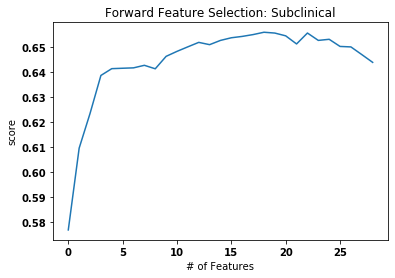

In [8]:
%%time
rsf = RandomSurvivalForest()
forward_feature_selection(rsf, X, y, 'Forward Feature Selection: Subclinical')


Ordering of Features: ['B2a_0g', 'murder_numg', 'ncar_cd', 'r4ag_0_cd', 'cjsig_0_cd', 'female', '%_povertyg', 'prsatx_cd', 'TRIg_0_cd', 'SESg_0_cd', 'adhdg_0_cd', 'CWSg_0_cd', 'gvsg_cd', 'primsev_amphetamines', 'primsev_opioids', 'primsev_alcohol', 'unemplmt_cd', 'pop_deng', 'homeless_0_cd', 'dssg_0_cd', 'primsev_other', 'srig_0_cd', 'nonwhite', 'primsev_cocaine', 'primsev_marijuana', 'epsg_0_cd', 'lrig_0_cd', 'PYS9Sxg_cd', 'cdsg_0_cd']
CPU times: user 32min 47s, sys: 2min 14s, total: 35min 1s
Wall time: 35min 11s


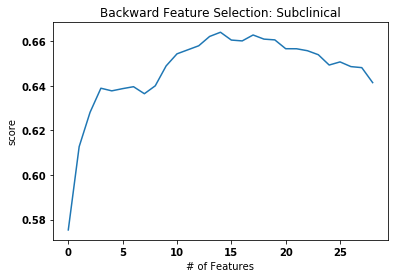

In [9]:
%%time
rsf = RandomSurvivalForest()
backward_feature_selection(rsf, X, y, 'Backward Feature Selection: Subclinical')

Mild Feature Importance

In [10]:
X = df[df.SUDSy_0_cd == 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2964, 29) (2964,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Ordering of Features: ['r4ag_0_cd', 'cjsig_0_cd', 'adhdg_0_cd', 'PYS9Sxg_cd', 'primsev_amphetamines', 'pop_deng', 'murder_numg', 'primsev_other', 'primsev_opioids', 'gvsg_cd', 'prsatx_cd', 'primsev_alcohol', 'primsev_cocaine', 'SESg_0_cd', 'unemplmt_cd', 'B2a_0g', 'TRIg_0_cd', '%_povertyg', 'female', 'nonwhite', 'homeless_0_cd', 'primsev_marijuana', 'CWSg_0_cd', 'ncar_cd', 'lrig_0_cd', 'cdsg_0_cd', 'srig_0_cd', 'epsg_0_cd', 'dssg_0_cd']
CPU times: user 20min 50s, sys: 1min 12s, total: 22min 3s
Wall time: 22min 9s


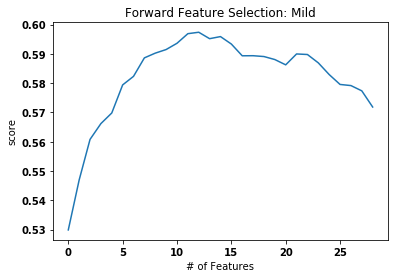

In [11]:
%%time
rsf = RandomSurvivalForest()
forward_feature_selection(rsf, X, y, 'Forward Feature Selection: Mild')


Ordering of Features: ['r4ag_0_cd', 'cjsig_0_cd', 'PYS9Sxg_cd', 'murder_numg', 'pop_deng', 'B2a_0g', 'ncar_cd', 'primsev_amphetamines', 'gvsg_cd', 'lrig_0_cd', 'primsev_alcohol', 'unemplmt_cd', 'homeless_0_cd', 'female', 'adhdg_0_cd', 'prsatx_cd', 'primsev_other', 'primsev_marijuana', 'primsev_opioids', 'primsev_cocaine', '%_povertyg', 'nonwhite', 'srig_0_cd', 'cdsg_0_cd', 'CWSg_0_cd', 'dssg_0_cd', 'epsg_0_cd', 'SESg_0_cd', 'TRIg_0_cd']
CPU times: user 29min 40s, sys: 2min 13s, total: 31min 54s
Wall time: 31min 58s


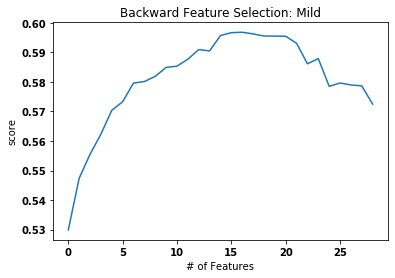

In [12]:
%%time
rsf = RandomSurvivalForest()
backward_feature_selection(rsf, X, y, 'Backward Feature Selection: Mild')

Severe Feature Importance

In [13]:
X = df[df.SUDSy_0_cd == 3]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(4354, 29) (4354,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Ordering of Features: ['dssg_0_cd', 'r4ag_0_cd', 'primsev_opioids', 'B2a_0g', 'pop_deng', 'primsev_alcohol', 'murder_numg', 'primsev_other', '%_povertyg', 'PYS9Sxg_cd', 'unemplmt_cd', 'ncar_cd', 'SESg_0_cd', 'primsev_amphetamines', 'nonwhite', 'cjsig_0_cd', 'CWSg_0_cd', 'homeless_0_cd', 'female', 'primsev_cocaine', 'prsatx_cd', 'TRIg_0_cd', 'srig_0_cd', 'primsev_marijuana', 'lrig_0_cd', 'epsg_0_cd', 'gvsg_cd', 'adhdg_0_cd', 'cdsg_0_cd']
CPU times: user 30min 50s, sys: 2min 35s, total: 33min 25s
Wall time: 34min 49s


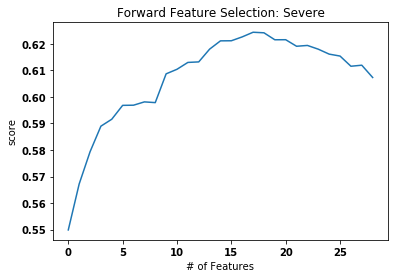

In [14]:
%%time
rsf = RandomSurvivalForest()
forward_feature_selection(rsf, X, y, 'Forward Feature Selection: Severe')


Ordering of Features: ['r4ag_0_cd', 'PYS9Sxg_cd', 'B2a_0g', '%_povertyg', 'SESg_0_cd', 'primsev_opioids', 'primsev_other', 'primsev_amphetamines', 'nonwhite', 'unemplmt_cd', 'dssg_0_cd', 'pop_deng', 'srig_0_cd', 'murder_numg', 'primsev_alcohol', 'female', 'primsev_cocaine', 'primsev_marijuana', 'lrig_0_cd', 'CWSg_0_cd', 'homeless_0_cd', 'TRIg_0_cd', 'gvsg_cd', 'adhdg_0_cd', 'cdsg_0_cd', 'epsg_0_cd', 'ncar_cd', 'prsatx_cd', 'cjsig_0_cd']
CPU times: user 46min 37s, sys: 4min 38s, total: 51min 16s
Wall time: 54min 4s


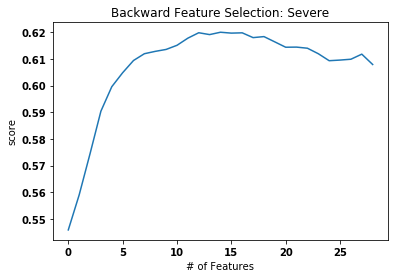

In [15]:
%%time
rsf = RandomSurvivalForest()
backward_feature_selection(rsf, X, y, 'Backward Feature Selection: Severe')

In [17]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(hours) + " hours " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 10 hours 600 minutes 44 seconds ---


In [18]:
%%bash
jupyter nbconvert --to html ./feature_selection.ipynb

[NbConvertApp] Converting notebook ./feature_selection.ipynb to html
[NbConvertApp] Writing 434026 bytes to ./feature_selection.html
